### Plan:
- dla każdego modelu OSOBNO poprzez crosswalidację sprawdzamy najlepsze rozkłady parametrów (SearchGrid lub bayesowsko)
- dla najlepszych parametrów (dla modelu) rysujemy auc curve i wypisujemy statystyki (sprawdzenie na zbiorze testowym) oraz wyniki z crosswalidacji na całym zbiorze danych
- następnie próbujemy stackingu, votingu itp
- znowu sprawdzamy boxploty
### Co przyjąłem
- do każdego modelu bierzemy pipeline z jednakowo preproccesingowanymi danymi: bez oczywistych kolumn (ale days zostawiam jednak przetransformowane kołowo), ponadto minmaxy i te binnery co były w poprzedniej części

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Ramka danych i preproccesing wstępny
from sklearn.model_selection import train_test_split

seed = 17
bank_data = pd.read_csv("./Data/bank_train_data.csv", index_col=0)

## Kategoryczne niebinarne
# Oridinal education
bank_data['education'] = bank_data['education'].map({'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3})

# OneHot reszty
bank_data = pd.get_dummies(bank_data, columns=['job','contact','marital','poutcome'])

## Kategoryczne binarne
binary = ["default", "housing", "loan", "y"]
for col in binary:
    bank_data[col] = bank_data[col].map({"yes": 1, "no": 0})

# Month (tranfosrmacja na okrąg)
bank_data['month'] = bank_data["month"].map({"jan": 0, "feb": 1, "mar": 2, "apr": 3, "may": 4, "jun": 5, "jul": 6, "aug": 7, "sep": 8, "oct": 9, "nov": 10, "dec": 11})
bank_data['month'] = bank_data["month"].apply(lambda x: np.sin(x * (2 * np.pi / 12)))

# Day (transformacja na okrąg)
bank_data['day'] = bank_data["day"].apply(lambda x: np.sin(x * (2 * np.pi / 31)))
X = bank_data.drop("y", axis=1)
y = bank_data["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y, test_size=0.2)

# 0. Pomocnicze

## 0.1 Klasy do pipeline

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Klasa do wyrzucania kolumn w pipelinie
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis = 1)
    
# Klasa do logarytmowania i następnie standaryzowania kolumn
class LogStdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.std_scalers = [StandardScaler() for _ in range(len(columns))]
    
    def fit(self, X, y=None):
        
        for i, col in enumerate(self.columns):
            self.std_scalers[i].fit(np.log1p(X[[col]]))
            
        return self
    
    def transform(self, X, y=None):
        
        df = X.copy()
        
        for i, col in enumerate(self.columns):
            df[col] = self.std_scalers[i].transform(np.log1p(X[[col]]))
        
        return df

# Klasa do binnowania cechy balance
class BalanceBinner(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        curr_balance = X["balance"]
        new_balance = balance = pd.cut(curr_balance, bins = [-np.inf, 0, 1500, np.inf], labels=[0, 1, 2]).cat.codes
        return X.drop("balance", axis=1).assign(balance = new_balance)
    
# Klasa do transoformowania cech na przedział (0, 1) (jednostajnie)
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scalers = [MinMaxScaler() for i in range(len(columns))]
        
    def fit(self, X, y=None):
        for i, col in enumerate(self.columns):
            self.scalers[i].fit(X[[col]])
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        for i, col in enumerate(self.columns):
            df[col] = self.scalers[i].transform(X[[col]])
        
        return df

# Klasa do binnowania cechy previous
class PreviousBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.assign(previous = np.where(X["previous"] == 0, 0, 1))

## 0.2 Funkcje

In [4]:
# !pip install -U imbalanced-learn
# !conda install -c conda-forge imbalanced-learn

In [5]:
# # Jakby imblearn nie działał
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [6]:
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, fbeta_score, roc_curve, auc, recall_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

# Do plotowania krzywej roc
def plot_roc_curve(model, title_model, X_test, y_test):
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f" % roc_auc)
    plt.title("ROC for: " + str(title_model).split('(')[0])
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.show()
    
# Funkcja do badania podstawowych scorów do baselinu
def base_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    precision = precision_score(y_test, y_hat)
    g_mean = geometric_mean_score(y_test, y_hat)
    accuracy = accuracy_score(y_test, y_hat)
    fbeta = fbeta_score(y_test, y_hat, beta=0.5)
    recall = recall_score(y_test,y_hat)
    print("Precision score:", precision)
    print("G-mean score:   ", g_mean)
    print("Accuracy score: ", accuracy)
    print("Fbeta_score:    ", fbeta)
    print("Recall score:", recall)
    print("Confusion matrix: \n", confusion_matrix(y_test, y_hat))
    return precision, g_mean, accuracy, fbeta, recall

def custom_fbeta_scorer(estimator, X, y):
    y_hat = estimator.predict(X)
    return fbeta_score(y, y_hat, beta=0.5)

def get_auc(model, X_test, y_test):
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    return auc(fpr, tpr)   

def custom_auc_scorer(estimator, X, y):
    return get_auc(estimator, X, y)

def custom_gmean_scorer(estimator, X, y):
    return geometric_mean_score(y, estimator.predict(X))

def get_my_pipe_with_model(model):
    pipe = Pipeline([
        ("dropper", ColumnDropper(["pdays", "default", 'poutcome_unknown', 'poutcome_other', 'contact_unknown', 'job_unknown'])),
        ("balance_binner", BalanceBinner()),
        ("bin_previous", PreviousBinner()),
        ("transformer _ minmax", MinMaxTransformer(["duration", "age", "campaign"])),
        ("model", model)
        ])
    return pipe

def crosswalidate_model_plot(model_cal, param_dict, X, y, n_repeats):
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=seed)
    stats = {"precision": np.array([]), "g-mean": np.array([]), "accuracy": np.array([]), "fbeta": np.array([]), "recall": np.array([]), "auc_score": np.array([])}
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        model = model_cal(**param_dict)
        pipe = get_my_pipe_with_model(model)
        pipe.fit(X.loc[train_idx], y.loc[train_idx])
        y_hat = pipe.predict(X.loc[test_idx])
        
        stats["precision"] = np.append(stats["precision"], precision_score(y.loc[test_idx], y_hat))
        stats["g-mean"] = np.append(stats["g-mean"], geometric_mean_score(y.loc[test_idx], y_hat))
        stats["accuracy"] = np.append(stats["accuracy"], accuracy_score(y.loc[test_idx], y_hat))
        stats["fbeta"] = np.append(stats["fbeta"], fbeta_score(y.loc[test_idx], y_hat, beta=0.5))
        stats["recall"] = np.append(stats["recall"], recall_score(y.loc[test_idx], y_hat))
        stats["auc_score"] = np.append(stats["auc_score"], get_auc(pipe, X.loc[test_idx], y.loc[test_idx]))
    
    df = pd.DataFrame(data=stats, columns=["precision", "g-mean", "accuracy", "fbeta", "recall", "auc_score"])
    ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
    ax.set_ylim([0, 1])
    ax.set_title("Crosswalidation results for: " + str(model))
    plt.show()
        
    

# 1. Modele

In [7]:
# ! pip install scikit-optimize

In [8]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV

In [9]:
n_iter = 100 # Może długo działać przy wartościach rzędu powyżej 10

## 1.1 RandomForest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real, Categorical, Integer

### 1.1.1 Fbeta - scorer

In [11]:
model = get_my_pipe_with_model(RandomForestClassifier(n_jobs=-1, random_state=seed))
opt = BayesSearchCV(
    estimator=model,
    search_spaces={
        "model__n_estimators": Integer(50, 150),
        "model__criterion": Categorical(["gini"]),
        "model__max_depth": Integer(4, 21),
        "model__min_samples_split": Integer(2, 8),
        "model__max_features": Integer(2, 10)
    },
    scoring=custom_fbeta_scorer, #fbeta z parametrem beta=0.5 (sprzyja bardziej precision)
    random_state=seed,
    n_iter=n_iter,
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

D:\Users\Bartek\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 14, 10, 2, 150] before, using random point ['gini', 6, 3, 6, 121]
  warnings.warn(


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('dropper',
                                         ColumnDropper(columns=['pdays',
                                                                'default',
                                                                'poutcome_unknown',
                                                                'poutcome_other',
                                                                'contact_unknown',
                                                                'job_unknown'])),
                                        ('balance_binner', BalanceBinner()),
                                        ('bin_previous', PreviousBinner()),
                                        ('transformer _ minmax',
                                         MinMaxTransformer(columns=['duration',
                                                                    'age',
                                                                    'campaign'])),
                                        ('model',
                                         RandomForestClassifier(n...
              search_spaces={'model__criterion': Categorical(categories=('gini',), prior=None),
                             'model__max_depth': Integer(low=4, high=21, prior='uniform', transform='normalize'),
                             'model__max_features': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize')})

In [12]:
# Jakie parametry wygrały
print("Best fbeta_score: ", opt.best_score_)
print("Best params: ", opt.best_params_)
opt.best_estimator_

Best fbeta_score:  0.5672785696340144
Best params:  OrderedDict([('model__criterion', 'gini'), ('model__max_depth', 15), ('model__max_features', 7), ('model__min_samples_split', 8), ('model__n_estimators', 149)])


Pipeline(steps=[('dropper',
                 ColumnDropper(columns=['pdays', 'default', 'poutcome_unknown',
                                        'poutcome_other', 'contact_unknown',
                                        'job_unknown'])),
                ('balance_binner', BalanceBinner()),
                ('bin_previous', PreviousBinner()),
                ('transformer _ minmax',
                 MinMaxTransformer(columns=['duration', 'age', 'campaign'])),
                ('model',
                 RandomForestClassifier(max_depth=15, max_features=7,
                                        min_samples_split=8, n_estimators=149,
                                        n_jobs=-1, random_state=17))])

Precision score: 0.5454545454545454
G-mean score:    0.489867988127989
Accuracy score:  0.8894154818325435
Fbeta_score:     0.4390243902439024
Recall score: 0.2465753424657534
Confusion matrix: 
 [[545  15]
 [ 55  18]]


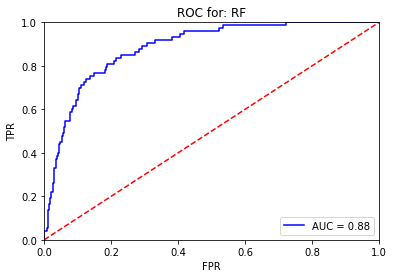

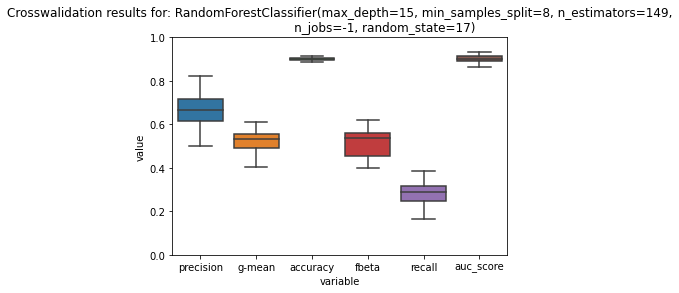

In [13]:
# Parametry dla testowego i crosswalidacyjne boxploty
param_dict={"n_jobs": -1,
            "n_estimators": opt.best_params_["model__n_estimators"],
            "criterion": opt.best_params_["model__criterion"], 
            "max_depth": opt.best_params_["model__max_depth"], 
            "min_samples_split": opt.best_params_["model__min_samples_split"], 
            "random_state": seed}

model = get_my_pipe_with_model(RandomForestClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "RF", X_test, y_test)
crosswalidate_model_plot(model_cal=RandomForestClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

### 1.1.2 Gmean - scorer

In [14]:
model = get_my_pipe_with_model(RandomForestClassifier(n_jobs=-1, random_state=seed))
opt = BayesSearchCV(
    estimator=model,
    search_spaces={
        "model__n_estimators": Integer(50, 150),
        "model__criterion": Categorical(["gini"]),
        "model__max_depth": Integer(4, 21),
        "model__min_samples_split": Integer(2, 8),
        "model__max_features": Integer(2, 10)
    },
    scoring=custom_gmean_scorer, # GMEAN
    random_state=seed,
    n_iter=n_iter,
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

D:\Users\Bartek\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 18, 9, 2, 149] before, using random point ['gini', 12, 7, 5, 99]
  warnings.warn(


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('dropper',
                                         ColumnDropper(columns=['pdays',
                                                                'default',
                                                                'poutcome_unknown',
                                                                'poutcome_other',
                                                                'contact_unknown',
                                                                'job_unknown'])),
                                        ('balance_binner', BalanceBinner()),
                                        ('bin_previous', PreviousBinner()),
                                        ('transformer _ minmax',
                                         MinMaxTransformer(columns=['duration',
                                                                    'age',
                                                                    'campaign'])),
                                        ('model',
                                         RandomForestClassifier(n...
              search_spaces={'model__criterion': Categorical(categories=('gini',), prior=None),
                             'model__max_depth': Integer(low=4, high=21, prior='uniform', transform='normalize'),
                             'model__max_features': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize')})

Best gmean_score:  0.6171242862364565
Best params OrderedDict([('model__criterion', 'gini'), ('model__max_depth', 21), ('model__max_features', 9), ('model__min_samples_split', 2), ('model__n_estimators', 145)])
------------------------------------------------------------------------------------------------
Precision score: 0.5666666666666667
G-mean score:    0.47693882814524924
Accuracy score:  0.8909952606635071
Fbeta_score:     0.4404145077720207
Recall score: 0.2328767123287671
Confusion matrix: 
 [[547  13]
 [ 56  17]]


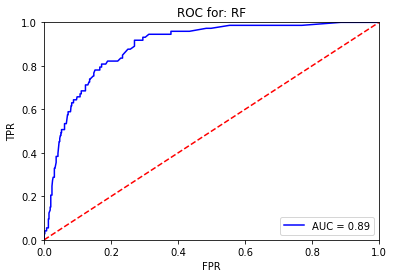

------------------------------------------------------------------------------------------------


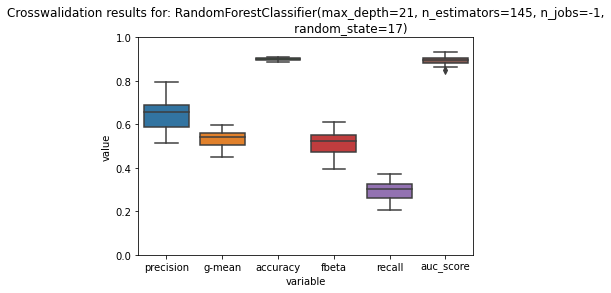

In [15]:
# Jakie parametry wygrały
print("Best gmean_score: ", opt.best_score_)
print("Best params", opt.best_params_)
print("------------------------------------------------------------------------------------------------")

# Jak zadziałał na zbiorze testowym
param_dict={"n_jobs": -1,
            "n_estimators": opt.best_params_["model__n_estimators"],
            "criterion": opt.best_params_["model__criterion"], 
            "max_depth": opt.best_params_["model__max_depth"], 
            "min_samples_split": opt.best_params_["model__min_samples_split"], 
            "random_state": seed}

model  = get_my_pipe_with_model(RandomForestClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "RF", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=RandomForestClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [16]:
params_for_rf = param_dict

## 1.2 GradientBooster

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier

### 1.2.1 Fbeta scorer

In [18]:
model = get_my_pipe_with_model(HistGradientBoostingClassifier())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__max_iter": [1000],
        "model__max_depth": [2, 3, 5, 8, 30],
        "model__max_leaf_nodes": [10, 30, None],
        "model__l2_regularization": [0, 0.1, 0.5, 1, 10],
        "model__random_state": [seed]
    },
    scoring=custom_fbeta_scorer, #fbeta z parametrem beta=0.5 (sprzyja bardziej precision)
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)
print("Best fbeta: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")

Best fbeta:  0.5502266588472776
Best params:  {'model__l2_regularization': 10, 'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__max_iter': 1000, 'model__max_leaf_nodes': 10, 'model__random_state': 17}
------------------------------------------------------------------------------------------------


Precision score: 0.625
G-mean score:    0.4496410832188264
Accuracy score:  0.8941548183254344
Fbeta_score:     0.4437869822485207
Recall score: 0.2054794520547945
Confusion matrix: 
 [[551   9]
 [ 58  15]]


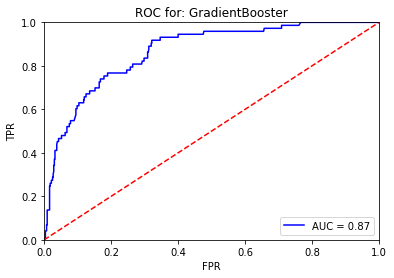

------------------------------------------------------------------------------------------------


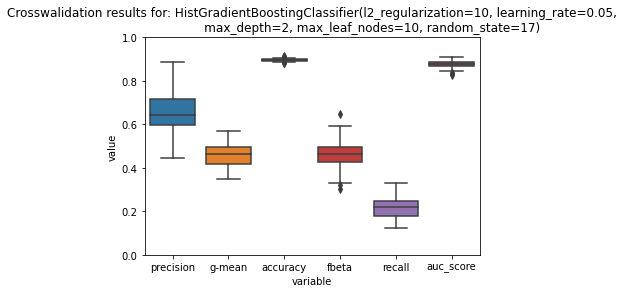

In [19]:
# Jak zadziałał na zbiorze testowym
param_dict = {
    "l2_regularization": opt.best_params_["model__l2_regularization"],
    "learning_rate": opt.best_params_["model__learning_rate"],
    "max_depth": opt.best_params_["model__max_depth"],
    "max_leaf_nodes": opt.best_params_["model__max_leaf_nodes"],
    "random_state": seed
}
model = get_my_pipe_with_model(HistGradientBoostingClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "GradientBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=HistGradientBoostingClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

### 1.2.2 GMean

In [20]:
model = get_my_pipe_with_model(HistGradientBoostingClassifier())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__max_iter": [1000],
        "model__max_depth": [3, 5, 8, 30],
        "model__max_leaf_nodes": [10, 30, None],
        "model__l2_regularization": [0, 0.1, 0.5, 1, 10],
        "model__random_state": [seed]
    },
    scoring=custom_gmean_scorer, #GMEAN
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        ColumnDropper(columns=['pdays',
                                                               'default',
                                                               'poutcome_unknown',
                                                               'poutcome_other',
                                                               'contact_unknown',
                                                               'job_unknown'])),
                                       ('balance_binner', BalanceBinner()),
                                       ('bin_previous', PreviousBinner()),
                                       ('transformer _ minmax',
                                        MinMaxTransformer(columns=['duration',
                                                                   'age',
                                                                   'campaign'])),
                                       ('model',
                                        HistGradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'model__l2_regularization': [0, 0.1, 0.5, 1, 10],
                         'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 8, 30],
                         'model__max_iter': [1000],
                         'model__max_leaf_nodes': [10, 30, None],
                         'model__random_state': [17]},
             scoring=<function custom_gmean_scorer at 0x000002012EDA0310>)

Best gmean:  0.6551926695613407
Best params:  {'model__l2_regularization': 0.5, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__max_iter': 1000, 'model__max_leaf_nodes': 10, 'model__random_state': 17}
------------------------------------------------------------------------------------------------
Precision score: 0.5882352941176471
G-mean score:    0.6289260252251289
Accuracy score:  0.8988941548183255
Fbeta_score:     0.5415162454873645
Recall score: 0.410958904109589
Confusion matrix: 
 [[539  21]
 [ 43  30]]


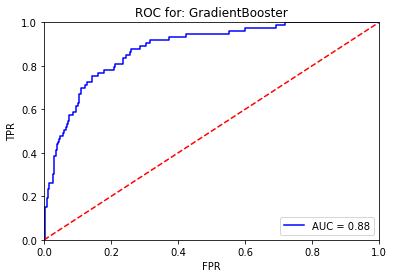

------------------------------------------------------------------------------------------------


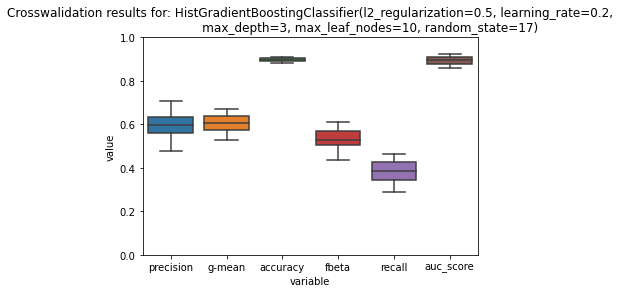

In [21]:
print("Best gmean: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")
# Jak zadziałał na zbiorze testowym
param_dict = {
    "l2_regularization": opt.best_params_["model__l2_regularization"],
    "learning_rate": opt.best_params_["model__learning_rate"],
    "max_depth": opt.best_params_["model__max_depth"],
    "max_leaf_nodes": opt.best_params_["model__max_leaf_nodes"],
    "random_state": seed
}
model = get_my_pipe_with_model(HistGradientBoostingClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "GradientBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=HistGradientBoostingClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [22]:
params_for_gradient_booster = param_dict

## 1. 3 XGB

In [1]:
#! pip install xgboost

In [2]:
from xgboost import XGBClassifier

### 1.3.1 fbeta - scorer

In [25]:
model = get_my_pipe_with_model(XGBClassifier())
opt = GridSearchCV(
    estimator=model,
param_grid={
        "model__eta": [0.05, 0.1, 0.2],
        "model__max_depth": [3, 6, 12, 30],
        "model__gamma": [0, 5, 10, 30, None],
        "model__min_child_weight": [1, 5, 10, 20],
        "model__lambda": [0.1, 0.5, 1, 5],
        "model__alpha": [0, 0.5, 1, 5],
        "model__scale_pos_weight": [7.67],
        "model__random_state": [seed]
    },
    scoring=custom_fbeta_scorer, #fbeta z parametrem beta=0.5 (sprzyja bardziej precision)
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        ColumnDropper(columns=['pdays',
                                                               'default',
                                                               'poutcome_unknown',
                                                               'poutcome_other',
                                                               'contact_unknown',
                                                               'job_unknown'])),
                                       ('balance_binner', BalanceBinner()),
                                       ('bin_previous', PreviousBinner()),
                                       ('transformer _ minmax',
                                        MinMaxTransformer(columns=['duration',
                                                                   'age',
                                                                   'campaign'])),
                                       ('model',
                                        XGBClassifier(base_score=...
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0, 0.5, 1, 5],
                         'model__eta': [0.05, 0.1, 0.2],
                         'model__gamma': [0, 5, 10, 30, None],
                         'model__lambda': [0.1, 0.5, 1, 5],
                         'model__max_depth': [3, 6, 12, 30],
                         'model__min_child_weight': [1, 5, 10, 20],
                         'model__random_state': [17],
                         'model__scale_pos_weight': [7.67]},
             scoring=<function custom_fbeta_scorer at 0x000002012EDA0160>)

Best fbeta:  0.5276681945345942
Best params:  {'model__alpha': 1, 'model__eta': 0.2, 'model__gamma': 0, 'model__lambda': 5, 'model__max_depth': 12, 'model__min_child_weight': 1, 'model__random_state': 17, 'model__scale_pos_weight': 7.67}
------------------------------------------------------------------------------------------------
Precision score: 0.5135135135135135
G-mean score:    0.6979141413726937
Accuracy score:  0.8878357030015798
Fbeta_score:     0.5149051490514904
Recall score: 0.5205479452054794
Confusion matrix: 
 [[524  36]
 [ 35  38]]


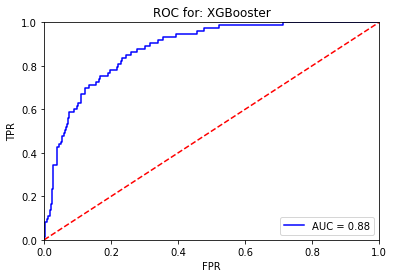

------------------------------------------------------------------------------------------------


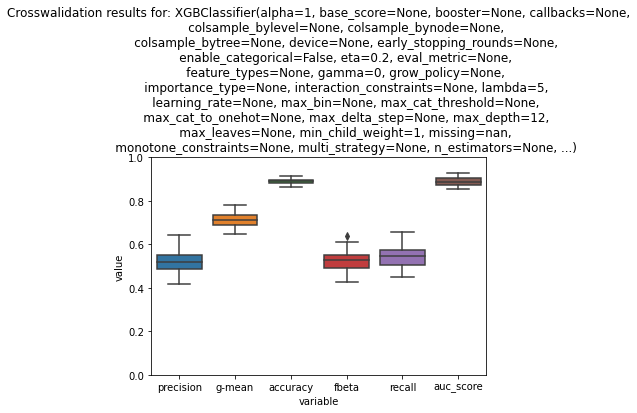

In [26]:
print("Best fbeta: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")
# Jak zadziałał na zbiorze testowym
param_dict = {
    "eta": opt.best_params_["model__eta"],
    "max_depth": opt.best_params_["model__max_depth"],
    "gamma": opt.best_params_["model__gamma"],
    "min_child_weight": opt.best_params_["model__min_child_weight"],
    "lambda": opt.best_params_["model__lambda"],
    "alpha": opt.best_params_["model__alpha"],
    "scale_pos_weight": opt.best_params_["model__scale_pos_weight"],
    "random_state": seed
}
model = get_my_pipe_with_model(XGBClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "XGBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=XGBClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

### 1.3.2 gmean_scorer

In [27]:
model = get_my_pipe_with_model(XGBClassifier())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__eta": [0.05, 0.1, 0.2],
        "model__max_depth": [3, 6, 12, 30],
        "model__gamma": [0, 5, 10, 30, None],
        "model__min_child_weight": [1, 5, 10, 20],
        "model__lambda": [0.1, 0.5, 1, 5],
        "model__alpha": [0, 0.5, 1, 5],
        "model__scale_pos_weight": [7.67],
        "model__random_state": [seed]
    },
    scoring=custom_gmean_scorer, #gmean
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        ColumnDropper(columns=['pdays',
                                                               'default',
                                                               'poutcome_unknown',
                                                               'poutcome_other',
                                                               'contact_unknown',
                                                               'job_unknown'])),
                                       ('balance_binner', BalanceBinner()),
                                       ('bin_previous', PreviousBinner()),
                                       ('transformer _ minmax',
                                        MinMaxTransformer(columns=['duration',
                                                                   'age',
                                                                   'campaign'])),
                                       ('model',
                                        XGBClassifier(base_score=...
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0, 0.5, 1, 5],
                         'model__eta': [0.05, 0.1, 0.2],
                         'model__gamma': [0, 5, 10, 30, None],
                         'model__lambda': [0.1, 0.5, 1, 5],
                         'model__max_depth': [3, 6, 12, 30],
                         'model__min_child_weight': [1, 5, 10, 20],
                         'model__random_state': [17],
                         'model__scale_pos_weight': [7.67]},
             scoring=<function custom_gmean_scorer at 0x000002012EDA0310>)

Best gmean:  0.824607697214239
Best params:  {'model__alpha': 5, 'model__eta': 0.1, 'model__gamma': 5, 'model__lambda': 0.5, 'model__max_depth': 3, 'model__min_child_weight': 20, 'model__random_state': 17, 'model__scale_pos_weight': 7.67}
------------------------------------------------------------------------------------------------
Precision score: 0.36423841059602646
G-mean score:    0.7901051479481007
Accuracy score:  0.8199052132701422
Fbeta_score:     0.40620384047267355
Recall score: 0.7534246575342466
Confusion matrix: 
 [[464  96]
 [ 18  55]]


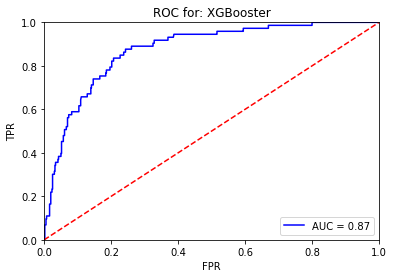

------------------------------------------------------------------------------------------------


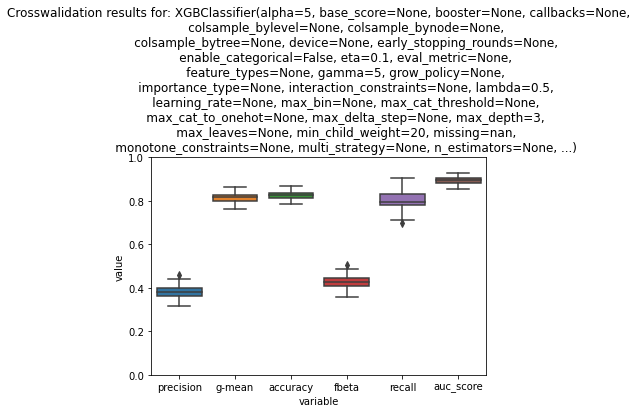

In [28]:
print("Best gmean: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")
# Jak zadziałał na zbiorze testowym
param_dict = {
    "eta": opt.best_params_["model__eta"],
    "max_depth": opt.best_params_["model__max_depth"],
    "gamma": opt.best_params_["model__gamma"],
    "min_child_weight": opt.best_params_["model__min_child_weight"],
    "lambda": opt.best_params_["model__lambda"],
    "alpha": opt.best_params_["model__alpha"],
    "scale_pos_weight": opt.best_params_["model__scale_pos_weight"],
    "random_state": seed
}
model = get_my_pipe_with_model(XGBClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "XGBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=XGBClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [29]:
params_for_xgb = param_dict

## 1.4 SVC

In [30]:
from sklearn.svm import SVC

### 1.4.1 Fbeta

Best fbeta:  0.3808809344442915
Best params: {'model__degree': 1, 'model__kernel': 'poly', 'model__max_iter': 150000, 'model__probability': True, 'model__random_state': 17}
------------------------------------------------------------------------------------------------
Precision score: 0.7916666666666666
G-mean score:    0.5078878792089432
Accuracy score:  0.9067930489731437
Fbeta_score:     0.5621301775147929
Recall score: 0.2602739726027397
Confusion matrix: 
 [[555   5]
 [ 54  19]]


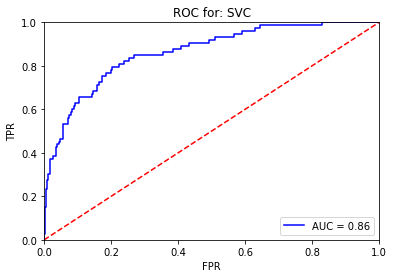

------------------------------------------------------------------------------------------------


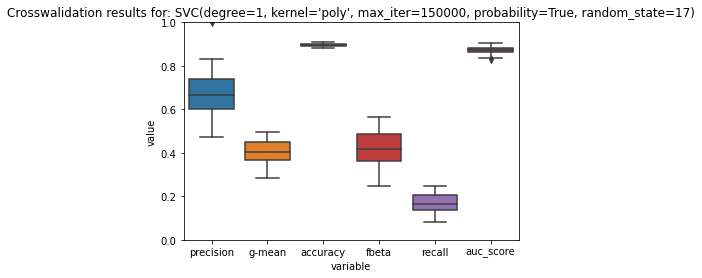

In [31]:
model = get_my_pipe_with_model(SVC())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "model__degree": [1, 3, 5, 7],
        "model__max_iter": [150000],
        "model__random_state": [seed],
        "model__probability": [True]
    },
    scoring=custom_fbeta_scorer, # beta
    cv=5
)

opt.fit(X_train, y_train)
print("Best fbeta: ", opt.best_score_)
print("Best params:", opt.best_params_)
print("------------------------------------------------------------------------------------------------")

# Jak zadziałał na zbiorze testowym
param_dict = {
    "kernel": opt.best_params_["model__kernel"],
    "degree": opt.best_params_["model__degree"],
    "max_iter": opt.best_params_["model__max_iter"],
    "random_state": seed,
    "probability": True
}
model = get_my_pipe_with_model(SVC(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "SVC", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=SVC, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [32]:
params_for_svc = param_dict

### 1.4.2 - gmean

Best gmean:  0.42043498558730885
Best params:  {'model__degree': 7, 'model__kernel': 'poly', 'model__max_iter': 15000, 'model__random_state': 17}
------------------------------------------------------------------------------------------------
Precision score: 0.4864864864864865
G-mean score:    0.4880669967805441
Accuracy score:  0.8830963665086888
Fbeta_score:     0.40723981900452494
Recall score: 0.2465753424657534
Confusion matrix: 
 [[541  19]
 [ 55  18]]


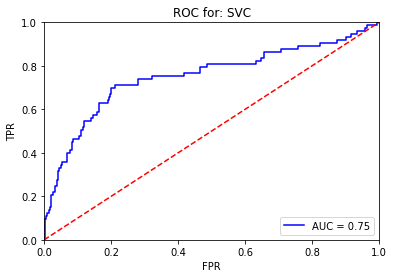

------------------------------------------------------------------------------------------------


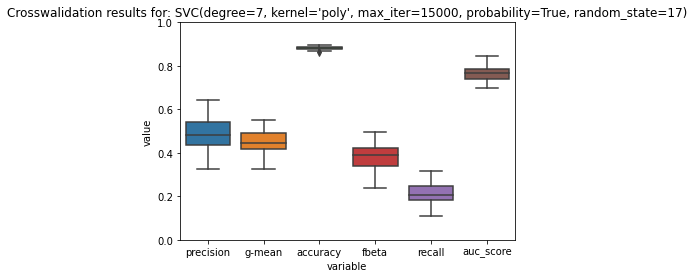

In [33]:
model = get_my_pipe_with_model(SVC())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "model__degree": [1, 3, 5, 7],
        "model__max_iter": [15000],
        "model__random_state": [seed]
    },
    scoring=custom_gmean_scorer, # g_mean
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

opt.fit(X_train, y_train)
print("Best gmean: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")

# Jak zadziałał na zbiorze testowym
param_dict = {
    "kernel": opt.best_params_["model__kernel"],
    "degree": opt.best_params_["model__degree"],
    "max_iter": opt.best_params_["model__max_iter"],
    "random_state": seed,
    "probability": True
}
model = get_my_pipe_with_model(SVC(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "SVC", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=SVC, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

# 2. Stacking - wstępny look

In [34]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

Precision score: 0.5652173913043478
G-mean score:    0.58604114787775
Accuracy score:  0.8941548183254344
Fbeta_score:     0.5058365758754864
Recall score: 0.3561643835616438
Confusion matrix: 
 [[540  20]
 [ 47  26]]


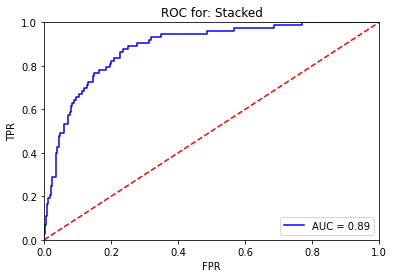

In [82]:
level0 = list()
level0.append(("rf", RandomForestClassifier(**params_for_rf)))
level0.append(("gradient_booster", HistGradientBoostingClassifier(**params_for_gradient_booster)))
level0.append(("xgb", XGBClassifier(**params_for_xgb)))
level0.append(("svc", SVC(**params_for_svc)))

level1 = LogisticRegression()

pipe = get_my_pipe_with_model(StackingClassifier(estimators = level0, final_estimator = level1, cv=5))
base_test_model(pipe, X_train, X_test, y_train, y_test)
plot_roc_curve(pipe, "Stacked", X_test, y_test)

Precision score: 0.6190476190476191
G-mean score:    0.5882076659794783
Accuracy score:  0.9004739336492891
Fbeta_score:     0.5394190871369295
Recall score: 0.3561643835616438
Confusion matrix: 
 [[544  16]
 [ 47  26]]


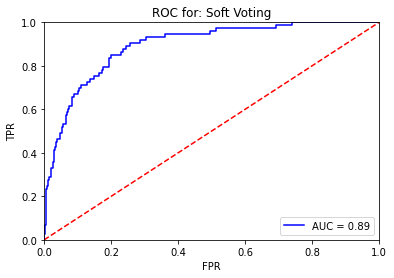

In [83]:
pipe = get_my_pipe_with_model(VotingClassifier(estimators=level0, voting="soft"))
base_test_model(pipe, X_train, X_test, y_train, y_test)
plot_roc_curve(pipe, "Soft Voting", X_test, y_test)

# 3. Ewaluacja modeli (pojedynczych)

In [54]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
def evaluate_model(model, X, y, scoring):
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=17)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

    return scores

In [51]:
# Parametry RandomForest
dict_forest_fbeta = {
    'criterion': 'gini',
    'max_depth': 15, 
    'max_features': 7, 
    'min_samples_split': 8, 
    'n_estimators': 149,
    "random_state": 17
}
dict_forest_gmean = {
    'n_jobs': -1,
    'n_estimators': 145,
    'criterion': 'gini',
    'max_depth': 21,
    'min_samples_split': 2,
    'random_state': 17
}
# Parametry GradientBooster
dict_gradient_fbeta = {
    'l2_regularization': 10, 
    'learning_rate': 0.05, 
    'max_depth': 2, 
    'max_iter': 1000, 
    'max_leaf_nodes': 10, 
    'random_state': 17
}
dict_gradient_gmean = {
    'l2_regularization': 0.5,
    'learning_rate': 0.2,
    'max_depth': 3,
    'max_leaf_nodes': 10,
    'max_iter': 1000,
    'random_state': 17
}
# Parametry XGBoost
dict_xgboost_fbeta = {
    'alpha': 1, 
    'eta': 0.2, 
    'gamma': 0, 
    'lambda': 5, 
    'max_depth': 12, 
    'min_child_weight': 1, 
    'random_state': 17, 
    'scale_pos_weight': 7.67
}
dict_xgboost_gmean = {
    'eta': 0.1,
    'max_depth': 3,
    'gamma': 5,
    'min_child_weight': 20,
    'lambda': 0.5,
    'alpha': 5,
    'scale_pos_weight': 7.67,
    'random_state': 17
}
# Parametry SVM
dict_svm_fbeta = {
    'kernel': 'poly',
    'degree': 1,
    'max_iter': 150000,
    'random_state': 17,
    'probability': True
}
dict_svm_gmean = {
    'degree': 7, 
    'kernel': 'poly', 
    'max_iter': 150000, 
    'random_state': 17,
    'probability': True}

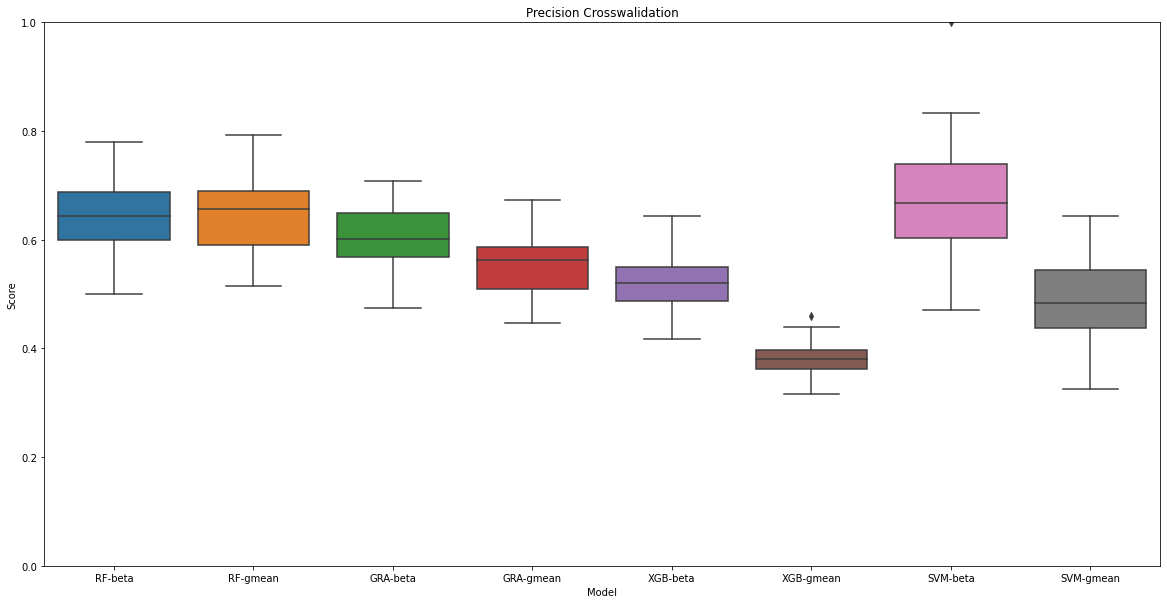

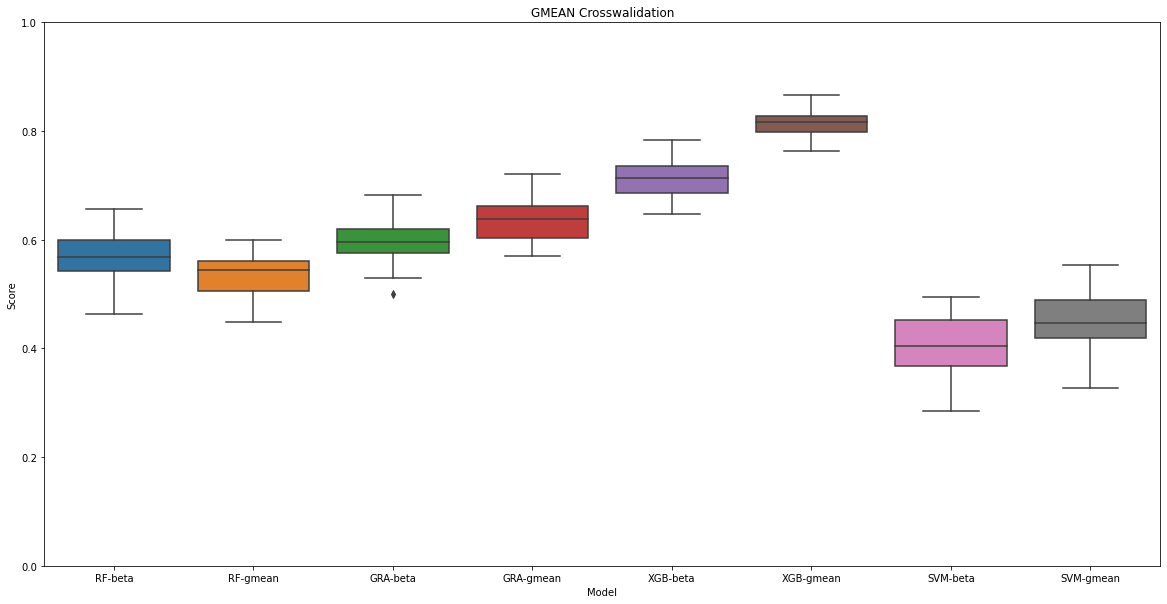

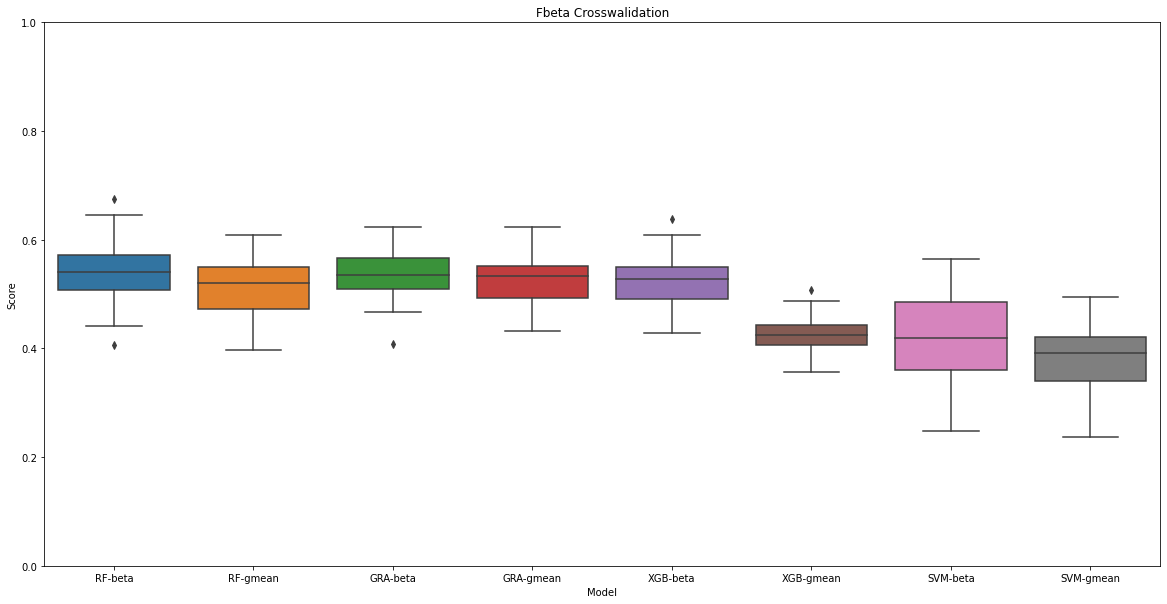

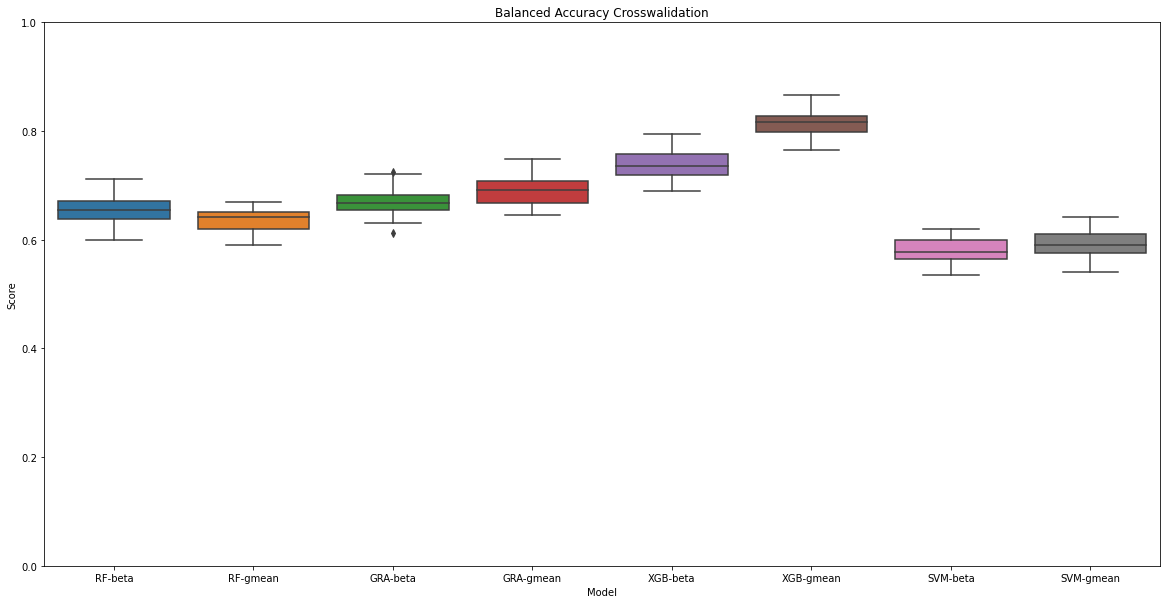

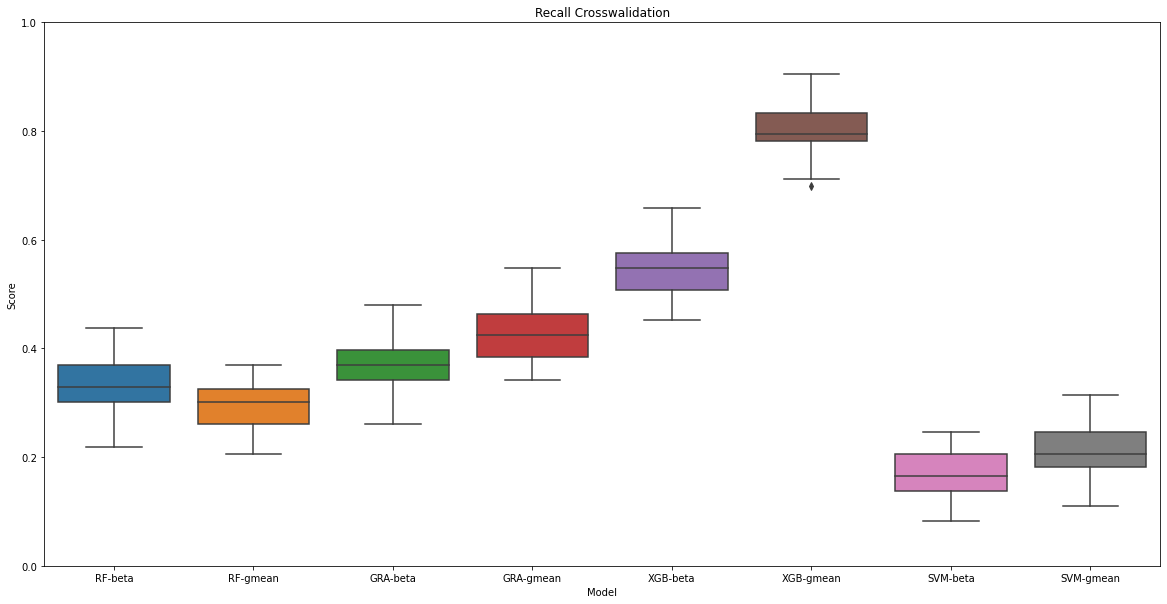

In [81]:
rf1 = get_my_pipe_with_model(RandomForestClassifier(**dict_forest_fbeta))
rf2 = get_my_pipe_with_model(RandomForestClassifier(**dict_forest_gmean))
gra1 = get_my_pipe_with_model(HistGradientBoostingClassifier(**dict_gradient_fbeta))
gra2 = get_my_pipe_with_model(HistGradientBoostingClassifier(**dict_gradient_gmean))
xgb1 = get_my_pipe_with_model(XGBClassifier(**dict_xgboost_fbeta))
xgb2 = get_my_pipe_with_model(XGBClassifier(**dict_xgboost_gmean))
svc1 = get_my_pipe_with_model(SVC(**dict_svm_fbeta))
svc2 = get_my_pipe_with_model(SVC(**dict_svm_gmean))

models = [rf1, rf2, gra1, gra2, xgb1, xgb2, svc1, svc2]
model_names = ["RF-beta", "RF-gmean", "GRA-beta", "GRA-gmean", "XGB-beta", "XGB-gmean", "SVM-beta", "SVM-gmean"]
scorings = ["precision", custom_gmean_scorer, custom_fbeta_scorer, "balanced_accuracy", "recall"]
scoring_names = ["Precision Crosswalidation", "GMEAN Crosswalidation", "Fbeta Crosswalidation", "Balanced Accuracy Crosswalidation", "Recall Crosswalidation"]
for i, scoring in enumerate(scorings):
    my_dict = dict()
    for j, model in enumerate(models):
        my_dict[j] = evaluate_model(model, X, y, scoring)
        
    df = pd.DataFrame(my_dict)
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
    
    ax.set_ylim([0, 1])
    ax.set_ylabel("Score")
    ax.set_xticklabels(model_names)
    ax.set_xlabel("Model")
    ax.set_title(scoring_names[i])
    
    plt.show()

# 4. Modele łączone

- Widać, że niektórych modeli nie warto brać do stacking (np. svm jest zbyt słaby w prorówaniu do reszty)
- Na pewno chcę wziąć do modeli xgboost-beta, xgboost-gmean
- Reszta modeli wsm wydaję się słabą opcją zatem zobaczę co się stanie po połączeniu tylko tych dwóch modeli
- Ta sekcja jest tylko do zobaczenia czy zadziałają w pętli

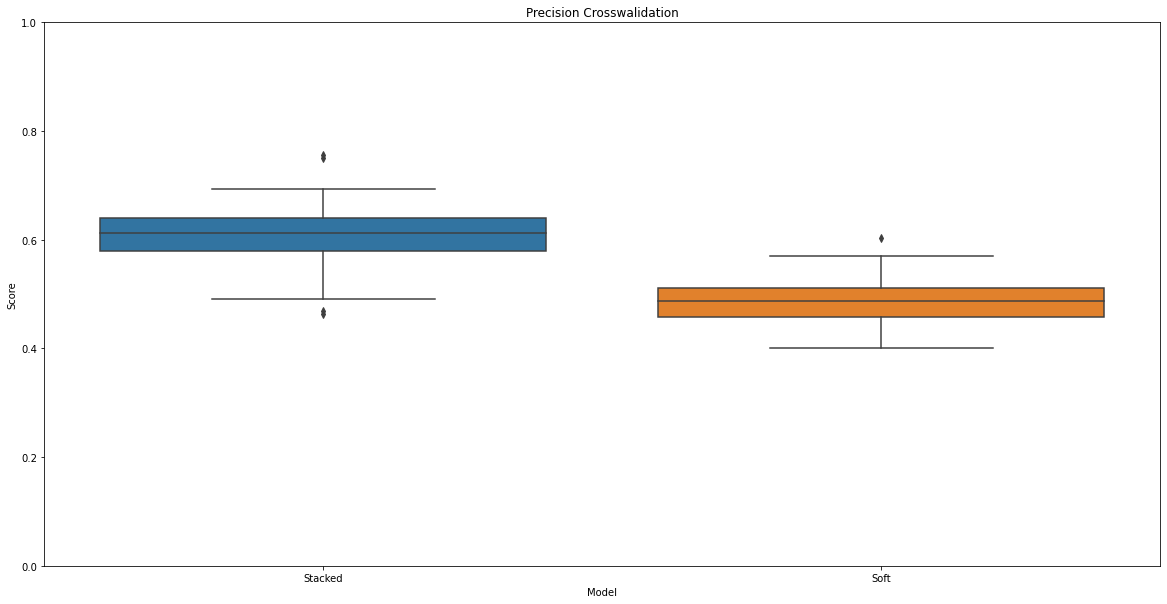

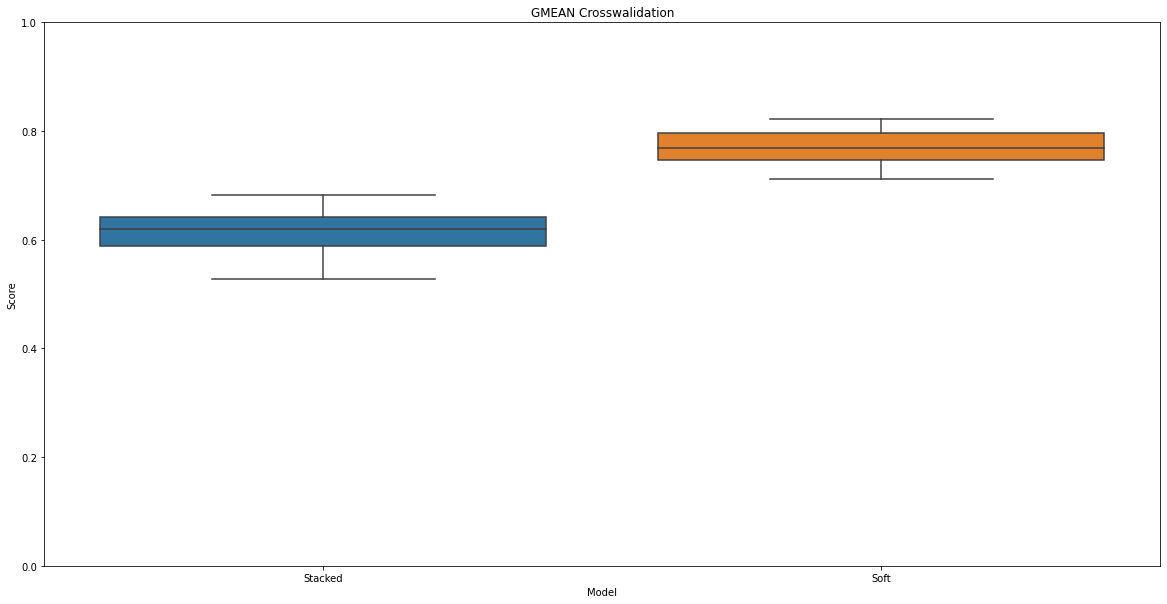

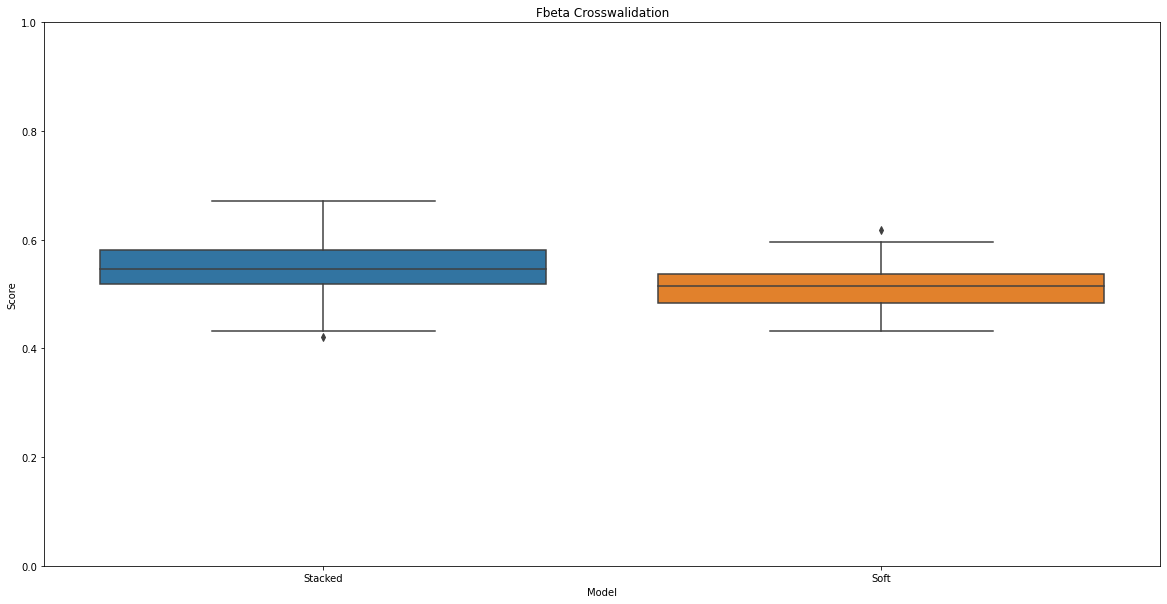

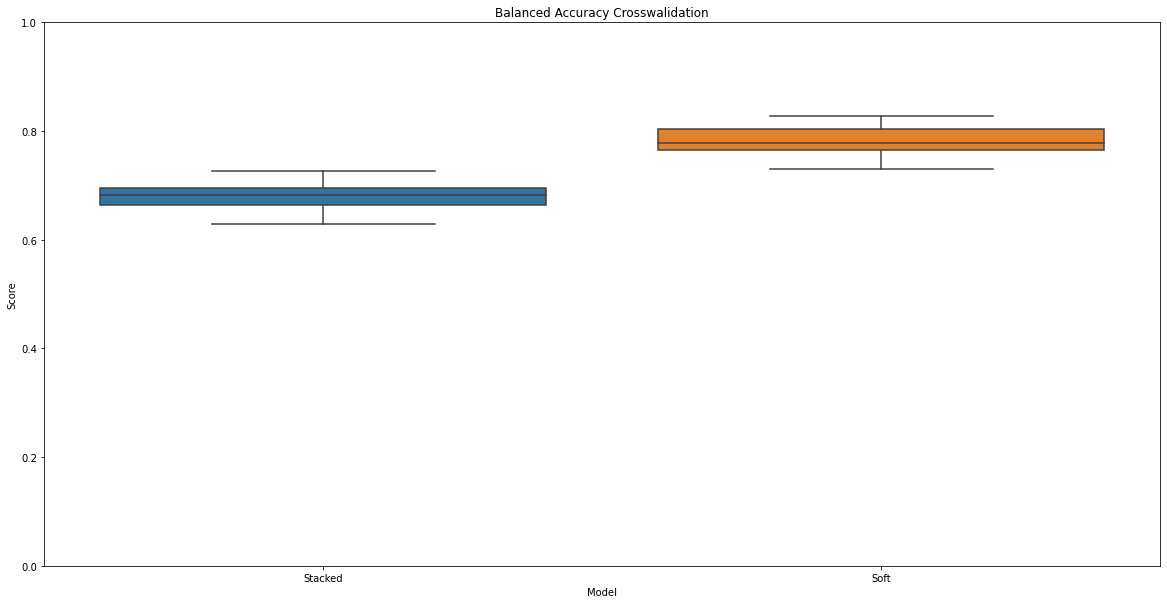

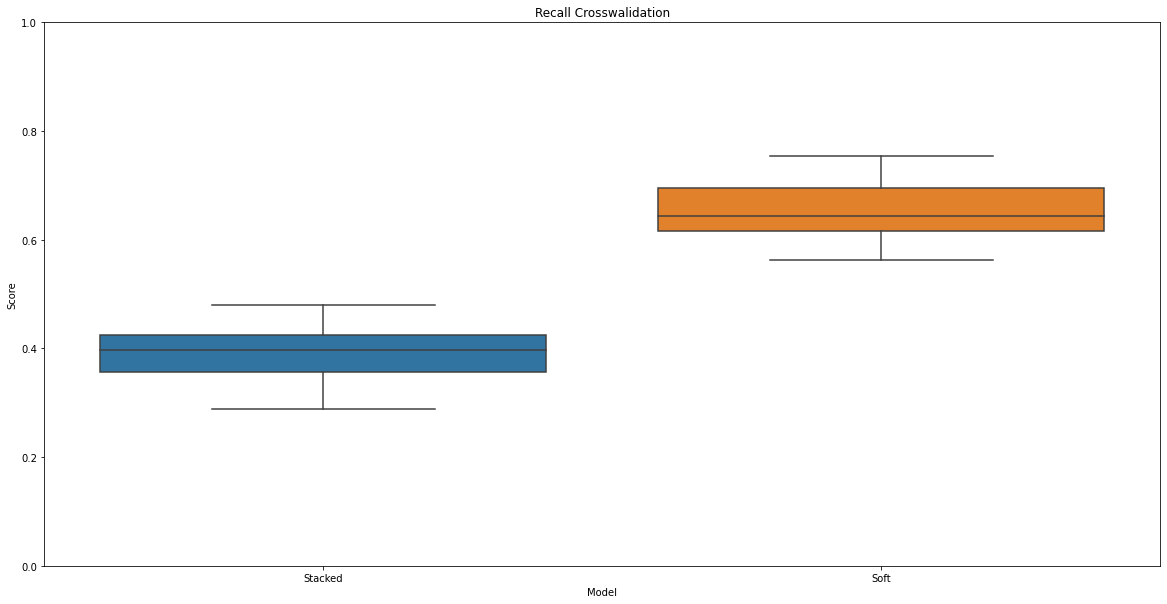

In [86]:
# Definicja modelu stacked
xgb1 = XGBClassifier(**dict_xgboost_fbeta)
xgb2 = XGBClassifier(**dict_xgboost_gmean)
level0 = [("beta", xgb1), ("gmean", xgb2)]
level1 = LogisticRegression()
stacked = get_my_pipe_with_model(StackingClassifier(estimators=level0, final_estimator=level1, cv=5))

# Definicja modelu soft
xgb1 = XGBClassifier(**dict_xgboost_fbeta)
xgb2 = XGBClassifier(**dict_xgboost_gmean)
level0 = [("beta", xgb1), ("gmean", xgb2)]
soft = get_my_pipe_with_model(VotingClassifier(estimators=level0, voting="soft"))

models = [stacked, soft]
model_names = ["Stacked", "Soft"]
scorings = ["precision", custom_gmean_scorer, custom_fbeta_scorer, "balanced_accuracy", "recall"]
scoring_names = ["Precision Crosswalidation", "GMEAN Crosswalidation", "Fbeta Crosswalidation", "Balanced Accuracy Crosswalidation", "Recall Crosswalidation"]
for i, scoring in enumerate(scorings):
    my_dict = dict()
    for j, model in enumerate(models):
        my_dict[j] = evaluate_model(model, X, y, scoring)
        
    df = pd.DataFrame(my_dict)
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
    
    ax.set_ylim([0, 1])
    ax.set_ylabel("Score")
    ax.set_xticklabels(model_names)
    ax.set_xlabel("Model")
    ax.set_title(scoring_names[i])
    
    plt.show()

# Ostateczne wykresy

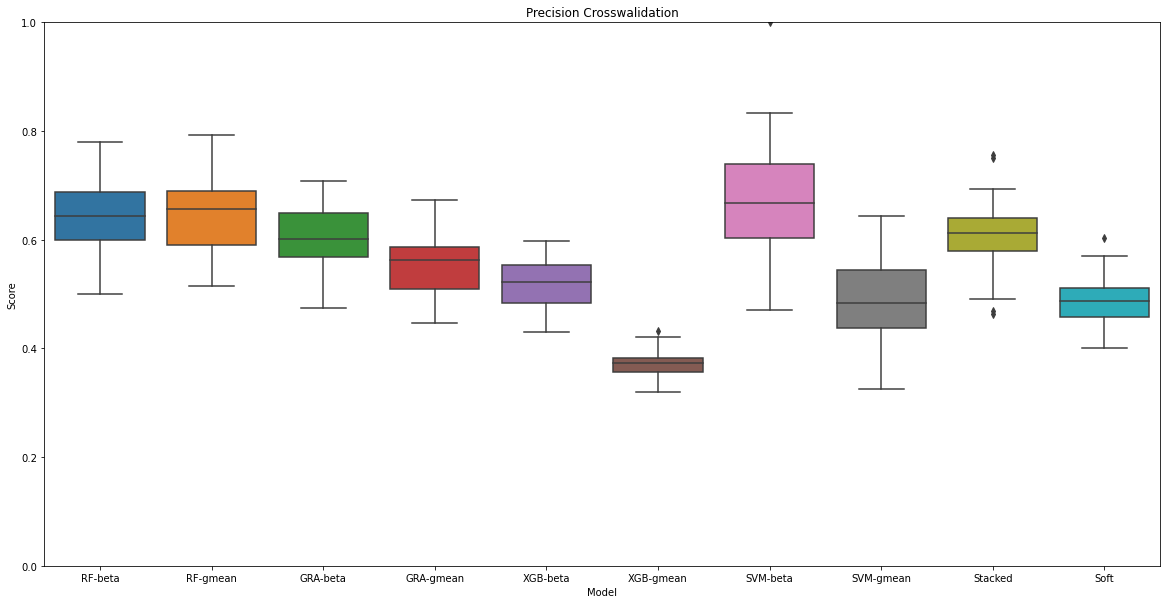

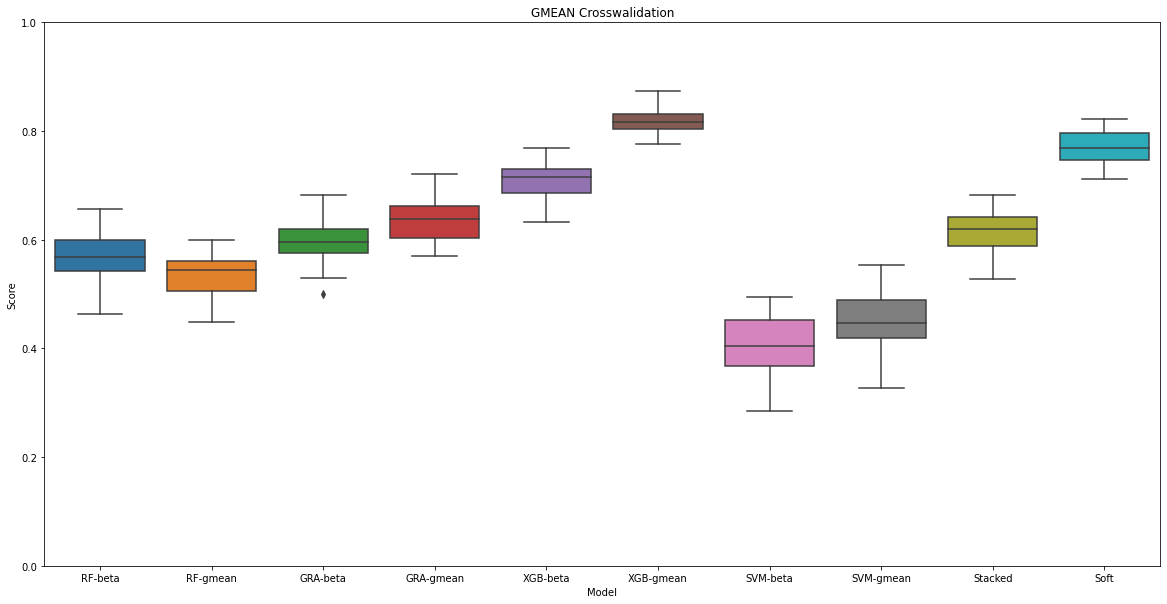

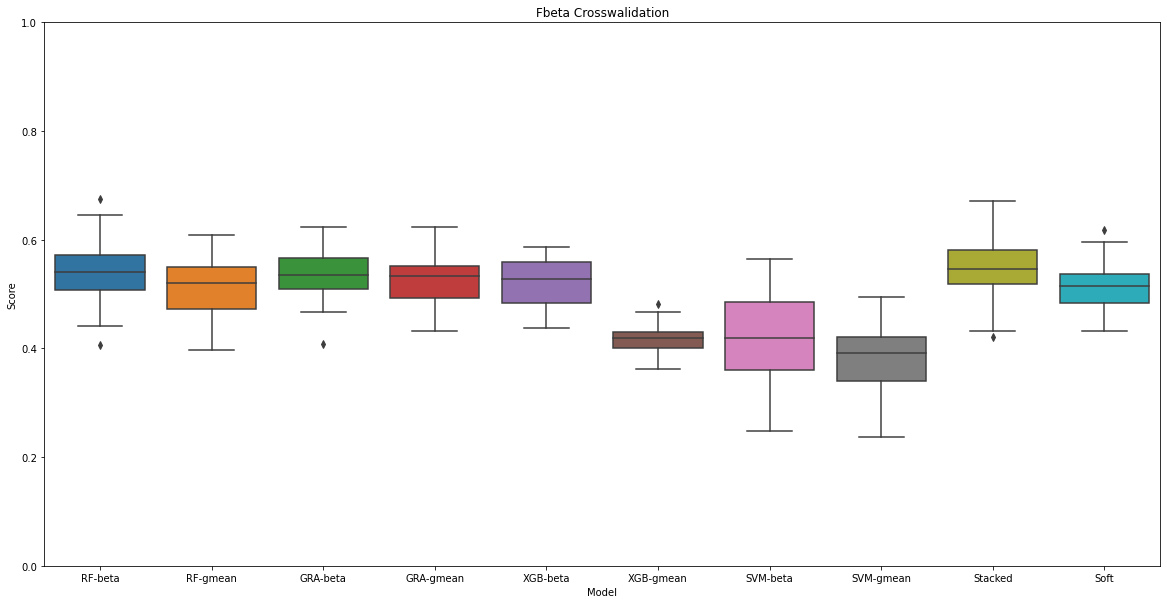

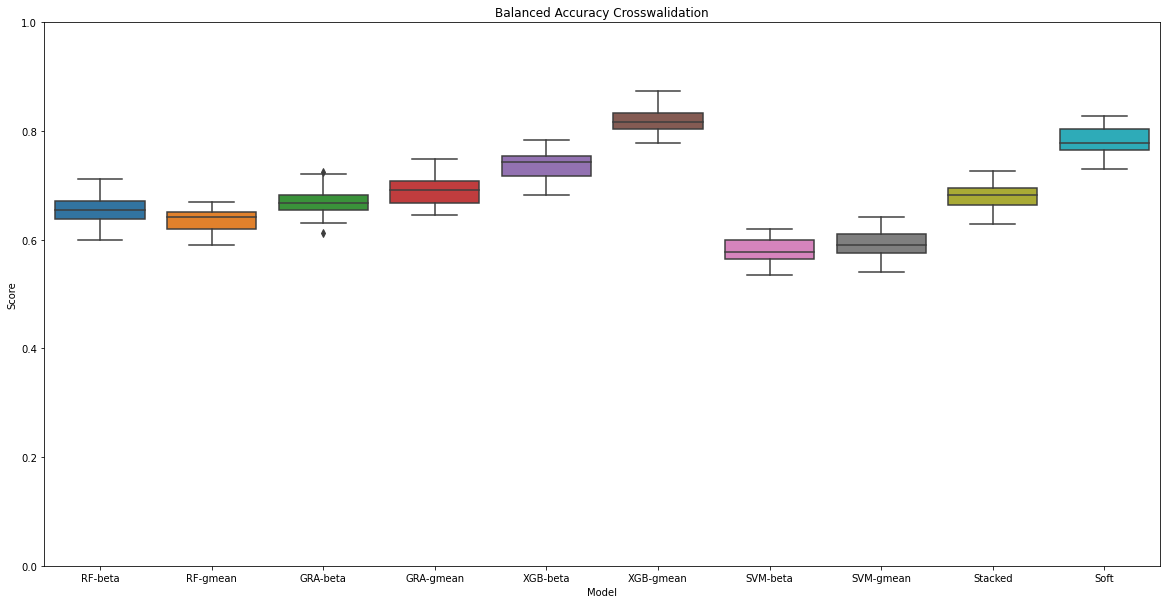

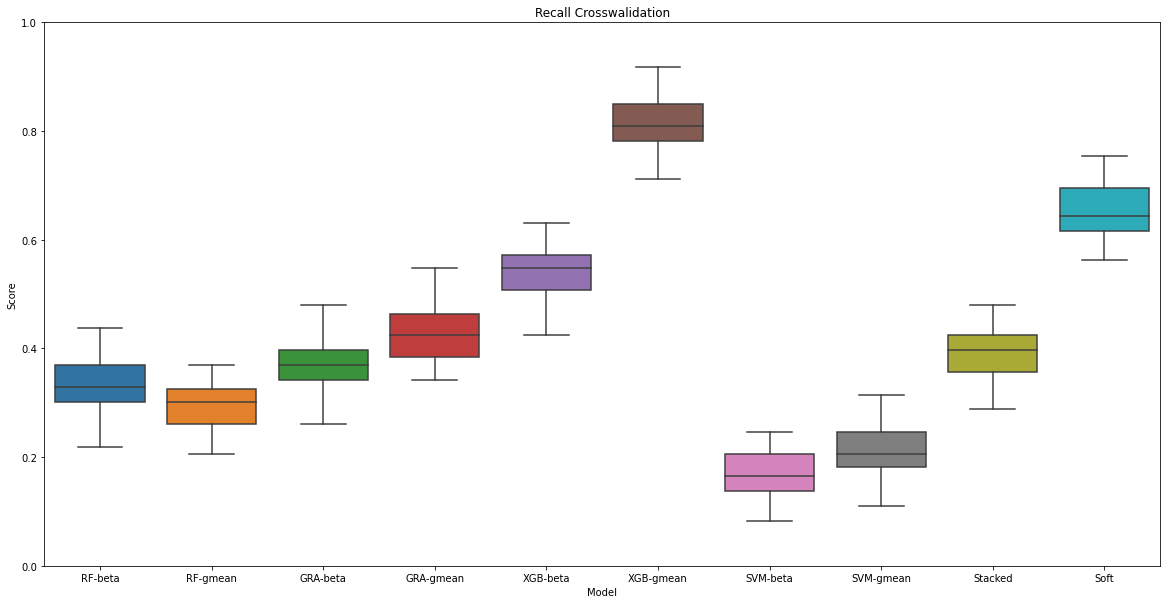

In [87]:
# Modele "pojedyncze"
rf1 = get_my_pipe_with_model(RandomForestClassifier(**dict_forest_fbeta))
rf2 = get_my_pipe_with_model(RandomForestClassifier(**dict_forest_gmean))
gra1 = get_my_pipe_with_model(HistGradientBoostingClassifier(**dict_gradient_fbeta))
gra2 = get_my_pipe_with_model(HistGradientBoostingClassifier(**dict_gradient_gmean))
xgb1 = get_my_pipe_with_model(XGBClassifier(**dict_xgboost_fbeta))
xgb2 = get_my_pipe_with_model(XGBClassifier(**dict_xgboost_gmean))
svc1 = get_my_pipe_with_model(SVC(**dict_svm_fbeta))
svc2 = get_my_pipe_with_model(SVC(**dict_svm_gmean))

# Definicja modelu stacked
xgb1 = XGBClassifier(**dict_xgboost_fbeta)
xgb2 = XGBClassifier(**dict_xgboost_gmean)
level0 = [("beta", xgb1), ("gmean", xgb2)]
level1 = LogisticRegression()
stacked = get_my_pipe_with_model(StackingClassifier(estimators=level0, final_estimator=level1, cv=5))

# Definicja modelu soft
xgb1 = XGBClassifier(**dict_xgboost_fbeta)
xgb2 = XGBClassifier(**dict_xgboost_gmean)
level0 = [("beta", xgb1), ("gmean", xgb2)]
soft = get_my_pipe_with_model(VotingClassifier(estimators=level0, voting="soft"))

models = [rf1, rf2, gra1, gra2, xgb1, xgb2, svc1, svc2, stacked, soft]
model_names = ["RF-beta", "RF-gmean", "GRA-beta", "GRA-gmean", "XGB-beta", "XGB-gmean", "SVM-beta", "SVM-gmean", "Stacked", "Soft"]
scorings = ["precision", custom_gmean_scorer, custom_fbeta_scorer, "balanced_accuracy", "recall"]
scoring_names = ["Precision Crosswalidation", "GMEAN Crosswalidation", "Fbeta Crosswalidation", "Balanced Accuracy Crosswalidation", "Recall Crosswalidation"]
for i, scoring in enumerate(scorings):
    my_dict = dict()
    for j, model in enumerate(models):
        my_dict[j] = evaluate_model(model, X, y, scoring)
        
    df = pd.DataFrame(my_dict)
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
    
    ax.set_ylim([0, 1])
    ax.set_ylabel("Score")
    ax.set_xticklabels(model_names)
    ax.set_xlabel("Model")
    ax.set_title(scoring_names[i])
    
    plt.show()

In [88]:
import os
os.system('jupyter nbconvert --to html model_and_hyperparameters.ipynb')

0